In [90]:
import datetime as dt
import numpy as np
import SEB_functions as SEBf
import matplotlib.pyplot as plt
import pandas as pd

from scipy.constants import Stefan_Boltzmann as SIGMA

In [91]:
SEBdata = SEBf.SEB_data(FileName="PKM-data/S10_SEB_2009_2019.txt")

The header has  88 entries.
AWS file 'S10_SEB_2009_2019.txt' has 91776 lines of data for 84 variables, start reading it.
Reading completed.
No data corrections needed for this station.


In [138]:
class CloseSEB():
    def __init__(self, SEBdata):
        self.T_air = SEBdata.Extract_Variable("Tair") + 273.15 # in degK
        self.T_surface = SEBdata.Extract_Variable("Tsurf_calc") + 273.15
        self.T2m = SEBdata.Extract_Variable("Tair_2m") + 273.15 # in degK
        self.P = SEBdata.Extract_Variable("pres")
        self.U10 = SEBdata.Extract_Variable("FF_10m")
        self.RH = SEBdata.Extract_Variable("RH")/100 # from % to fraction
        self.SHF_initial = SEBdata.Extract_Variable("Hsen")
        self.G = SEBdata.Extract_Variable("Gs")
        self.SWdown = SEBdata.Extract_Variable("SWin_corr")
        self.SWup = SEBdata.Extract_Variable("SWout")
        self.SWnet = SEBdata.Extract_Variable("SWnet_corr")
        self.LWup = SEBdata.Extract_Variable("LWout_model")
        self.LWdown = SEBdata.Extract_Variable("LWin")
        self.LWnet_model = SEBdata.Extract_Variable('LWnet_model')
        self.LHF_initial = SEBdata.Extract_Variable("Hlat")
        self.melt_initial= SEBdata.Extract_Variable("melt_energy")
        self.res_initial = SEBdata.Extract_Variable("rest_energy")
        #Find constants
        self.c_tbd = self.find_ctbd()
        self.epsilon = self.find_epsi()
        self.alpha = self.find_alpha()

    def find_ctbd(self):
        '''Function to calculate infamous c_tbd'''
        SHF = self.SHF_initial
        T_air2m = self.T2m
        T_surf = self.T_surface
        c_tbd = np.array(SHF)/(self.U10* (np.array(T_air2m) - np.array(T_surf)))
        c_tbd = np.array(c_tbd)
        c_tbd[c_tbd < 0] = 0
        c_tbd[c_tbd > 25] = 25
        

        self.c_tbd = c_tbd
        return c_tbd
    
    def find_alpha(self):
        cl_arr = []
        mv = 18.0153 #g/mol
        mair = 28.9644 #g/mol
        for (T, RH, P, U10, LHF_init) in zip(self.T_air, self.RH, self.P, self.U10, self.LHF_initial):
            if T <= 273.15:
                c_1 = 22.587
                c_2 = 273.68 #in C
            elif T > 273.15:
                c_1 = 17.502
                c_2 = 240.97 #in C
            else:
                c_1 = 17.502
                c_2 = 240.97 #in C
            Qsat = 6.1121*mv/(P*mair)*np.exp(c_1*(T - 273.15)/(c_2+(T - 273.15)))
            cl = LHF_init/(U10*(Qsat*(RH-1)))
            cl_arr.append(cl)

        cl_arr = np.array(cl_arr)
        c_tbd = self.c_tbd
    
        clmax = 100000
        clmin = -50000

        mask = (cl_arr > clmin) & (cl_arr < clmax) & ~np.isnan(cl_arr)
    
        cl_arr_fit = cl_arr[mask]
        c_tbd_fit = c_tbd[mask]
        alpha = np.polyfit(c_tbd_fit,cl_arr_fit,1)
        return alpha[0]
    
    def find_epsi(self):
        epsilon = self.LWdown/(SIGMA*(self.T2m**4))
        self.epsilon = epsilon
        return epsilon

    def print_var(self, var):
        '''easy return of variable'''
        return getattr(self, var)

    def LWadjdown(self, Tatm, dT):
        '''Function to convert temperature anomaly to LW down in W/m2'''
        LW_adj_down = self.epsilon * SEBf.convert_T_in_LWout(Tatm + dT, Celcius=False)*-1 
        return LW_adj_down
    
    def get_Qsat(self,T, P):
        mv = 18.0153 #g/mol
        mair = 28.9644 #g/mol

        if T <= 273.15:
            c_1 = 22.587
            c_2 = 273.68 #in C
        elif T > 273.15:
            c_1 = 17.502
            c_2 = 240.97 #in C
        else:
            return np.nan
        
        Qsat = 6.1121*mv/(P*mair)*np.exp(c_1*(T - 273.15)/(c_2+(T - 273.15)))
        return Qsat
    
    def find_LHF(self,T2m, T_surf, P, U10, RH,c_tbd):
        '''Function to calculate the latent heat flux from the 2m temperature, pressure, relative humidity and wind speed'''
        Qsat_surf = self.get_Qsat(T_surf, P)
        Qsat_2m = self.get_Qsat(T2m, P)
        cs = self.alpha*c_tbd
        LHF =  cs * U10 * (RH*Qsat_2m - Qsat_surf) 
        if LHF < -80:
            LHF = -80
        return LHF

    def calc_Tsurf(self,T_surf_est,T_surf_0, T_air,dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,T2m,epsilon):
        '''
        Calculate the surface temperature from the bulk temperature and the wind speed
        LW_up = LW_up0 + dLW_up
        LW_up0 = -SIGMA*(T_surf)**4 --> replace with LW_up
        dLW_up = -4*SIGMA*(T_surf**3)*(T_surf_adj-T_surf)
        '''
        LHF = self.find_LHF(T2m, T_surf_est,P,U10,RH,c_tbd)

        c_adj = 4*(T_surf_est**3)*SIGMA + c_tbd*U10
        c_fixed = SWnet + LWadjdown + 3*SIGMA*T_surf_est**4 + SHF + U10*c_tbd*(dT+T_surf_0) + LHF + G
        
        T_surf_adj =  c_fixed/c_adj
        if T_surf_adj > 273.15:
            T_surf_adj = 273.16
        LW_adj_up = -SIGMA * T_surf_adj**4#-SIGMA*(T_surf_est)**4 - 4*SIGMA*(T_surf_est**3)*(T_surf_adj-T_surf_est) #SEBf.convert_T_in_LWout(T_surf_adj, Celcius=False)
        LW_adj_down = epsilon*SIGMA*(T2m)**4
        SHF_adj = SHF + U10*c_tbd*(dT-(T_surf_adj-T_surf_0))
        LHF_adj = LHF
        
        return T_surf_adj, LW_adj_up, LW_adj_down,SHF_adj, LHF_adj
        
    def calculate_melting(self,T_surf,T_surf_0,T_air,dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G, T2m):
        '''Function to calculate the melting energy from the surface temperature, pressure, relative humidity and wind speed''' 
        LHF = self.find_LHF(T2m, T_surf,P, U10, RH,c_tbd)
        
        c_adj = 4*(T_surf**3)*SIGMA + c_tbd*U10
        c_fixed = SWnet + LWadjdown + 3*SIGMA*(T_surf**4) + SHF + U10*c_tbd*(dT+T_surf_0) + LHF + G

        M = (c_fixed-c_adj*T_surf) 

        return M
    
    def calculate_SEB(self,T_surface, T_surf_0, T_air,dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,T2m,epsilon,idx=0,idxmax=10):
        '''Function to calculate the surface energy balance from the surface temperature, pressure, relative humidity and wind speed'''
        T_surf_updated,LW_up,LWdown,SHFn,LHFn = self.calc_Tsurf(T_surface, T_surf_0, T_air,dT,LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m,epsilon=epsilon) 
            # print(T_surface, dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,idx,idxmax,get_Fluxes)
        
         
        if idx == idxmax:
            res = self.calculate_melting(T_surf_updated, T_surf_0=T_surf_0,T_air=T_air,dT=dT,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G, T2m=T2m)
            if res > 0:
                M = res
                res = 0
                T_surf = T_surf_updated
            else:
                M = 0
                T_surf = T_surf_updated
            return M, res, T_surf,LW_up,LWdown,SHFn,LHFn
        
        elif T_surf_updated > 273.15:
            T_surf = 273.16#T_surf_updated
            M = self.calculate_melting(T_surf=T_surf, T_surf_0=T_surf_0,T_air=T_air,dT=dT,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,T2m=T2m,SHF=SHF,G=G)
            res = 0
            if M < 0:
                return self.calculate_SEB(T_surface=T_surf_updated, T_surf_0=T_surf_0, T_air=T_air,dT=dT,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m,epsilon=epsilon,idx=idx+1, idxmax=idxmax)
                # break
                res = M
                M = 0
            return M, res, T_surf,LW_up,LWdown,SHFn,LHFn
        
        elif T_surf_updated <= 273.15:
            return self.calculate_SEB(T_surface=T_surf_updated, T_surf_0=T_surf_0, T_air=T_air,dT=dT,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m,epsilon=epsilon,idx=idx+1, idxmax=idxmax)

        else: # T_comp is a nan or something
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        

    
    def fetch_SEB(self, LWadjdown, dT, idxmax=10):
        '''Function to fetch the SEB'''
        SEB_dict = {}
        M_ar = []
        res_ar = [] 
        T_surf_ar = [] 

        LW_adj_up_arr = []
        LW_adj_down_arr = []
        SHF_adj_arr = []
        LHF_adj_arr = []


        
        for idx, (T_s, T_air,P, RH, c_tbd,U10, SWnet, LWad, SHF, G,T2m,epsilon) in enumerate(zip(self.T_surface, self.T_air,self.P, self.RH, self.c_tbd,self.U10,self.SWnet,LWadjdown,self.SHF_initial,self.G,self.T2m,self.epsilon)):
            T2m = T2m + dT
            # print(T_s, P, RH, c_tbd,U10, SWnet, LWad, SHF, G)
            M, res, T_surf,LW_up,LWdown,SHFn,LHFn = self.calculate_SEB(T_surface=T_s, T_surf_0=T_s, T_air=T_air,dT=dT,LWadjdown=LWad,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m,epsilon=epsilon,idxmax=idxmax)
            M_ar.append(M)
            res_ar.append(res)
            T_surf_ar.append(T_surf)
            

            LW_adj_up_arr.append(LW_up)
            LW_adj_down_arr.append(LWdown)
            SHF_adj_arr.append(SHFn)
            LHF_adj_arr.append(LHFn)


        SEB_dict = {'Melt': M_ar, 'Res': res_ar, 'T_surf': T_surf_ar}

        SEB_dict.update({'LW_adj_up': LW_adj_up_arr, 'LW_adj_down': LW_adj_down_arr, 'SHF_adj': SHF_adj_arr, 'LHF_adj': LHF_adj_arr})
        return SEB_dict
        

In [139]:
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)

dT = 1
SEB = CloseSEB(SEBdata)
LWadjdown = SEB.LWadjdown(SEB.T_air, dT=dT)
melt_dict_fluxes = SEB.fetch_SEB(LWadjdown=LWadjdown, dT=dT, idxmax=10)

In [140]:
SEB.alpha

2766.6469672290827

In [141]:
df = pd.DataFrame(melt_dict_fluxes)
df.head(10)

,Melt,Res,T_surf,LW_adj_up,LW_adj_down,SHF_adj,LHF_adj
0,0.0,-3.081732e-08,253.469034,-234.051471,158.442410,-57.529496,-9.882995
1,0.0,-2.105480e-10,248.748944,-217.098448,163.737319,-18.031989,-2.372843
2,0.0,-7.094059e-11,247.459723,-212.632590,167.708769,-12.947615,-1.553959
3,0.0,-3.819878e-11,246.840707,-210.512971,171.576109,-11.010154,-1.259506
4,0.0,-2.592060e-11,246.647227,-209.853726,176.252841,-9.577494,-1.081025
5,0.0,-1.909939e-11,246.121280,-208.069486,177.988734,-11.529865,-1.298837
6,0.0,-1.091394e-11,245.539710,-206.109822,177.487870,-11.961025,-1.316538
7,0.0,-3.910827e-11,246.496389,-209.340851,175.258006,-29.532634,-3.166007
8,0.0,-4.092726e-11,246.390129,-208.980112,175.765523,-29.219756,-3.140966
9,0.0,-3.456080e-11,246.273062,-208.583226,176.979731,-21.879933,-2.551380


In [221]:
def plot_nice_figures(SEBdata, var, original, var_str, ax, ylabel=True, differences=False):
    '''Function to plot daily mean values of a variable'''
    AverageFunction = SEBf.get_daily_average
    Range  = [dt.datetime.fromisoformat("2017-01-01"), dt.datetime.fromisoformat("2018-01-01")]
    Label  = "Date"
    Xdata = AverageFunction(var, SEBdata.DateTime, GiveDatesBack=True)[1]

    daily_mean = AverageFunction(var, SEBdata.DateTime)
    daily_og_mean = AverageFunction(original, SEBdata.DateTime)

    if not differences:
        ax.plot(Xdata, daily_mean,label=f'Daily averaged {var_str} for +1K')
        ax.plot(Xdata,daily_og_mean,alpha=0.5,label=f'Daily averaged initial {var_str}')
        
        
        
        # ax.set_ylim(-1,100)
    if differences:
        ax.plot(Xdata, np.array(daily_mean)-np.array(daily_og_mean),label=f'Difference between daily averaged {var_str} for +1K')

    if ylabel:
        if var == melt_dict_fluxes['T_surf']:
            ax.set_ylabel("Temperature (K)")
        else:
            ax.set_ylabel("Energy flux (W/m2)")
            
    ax.set_xlabel(Label)
    ax.grid()
    ax.legend()
    ax.set_xlim(Range)


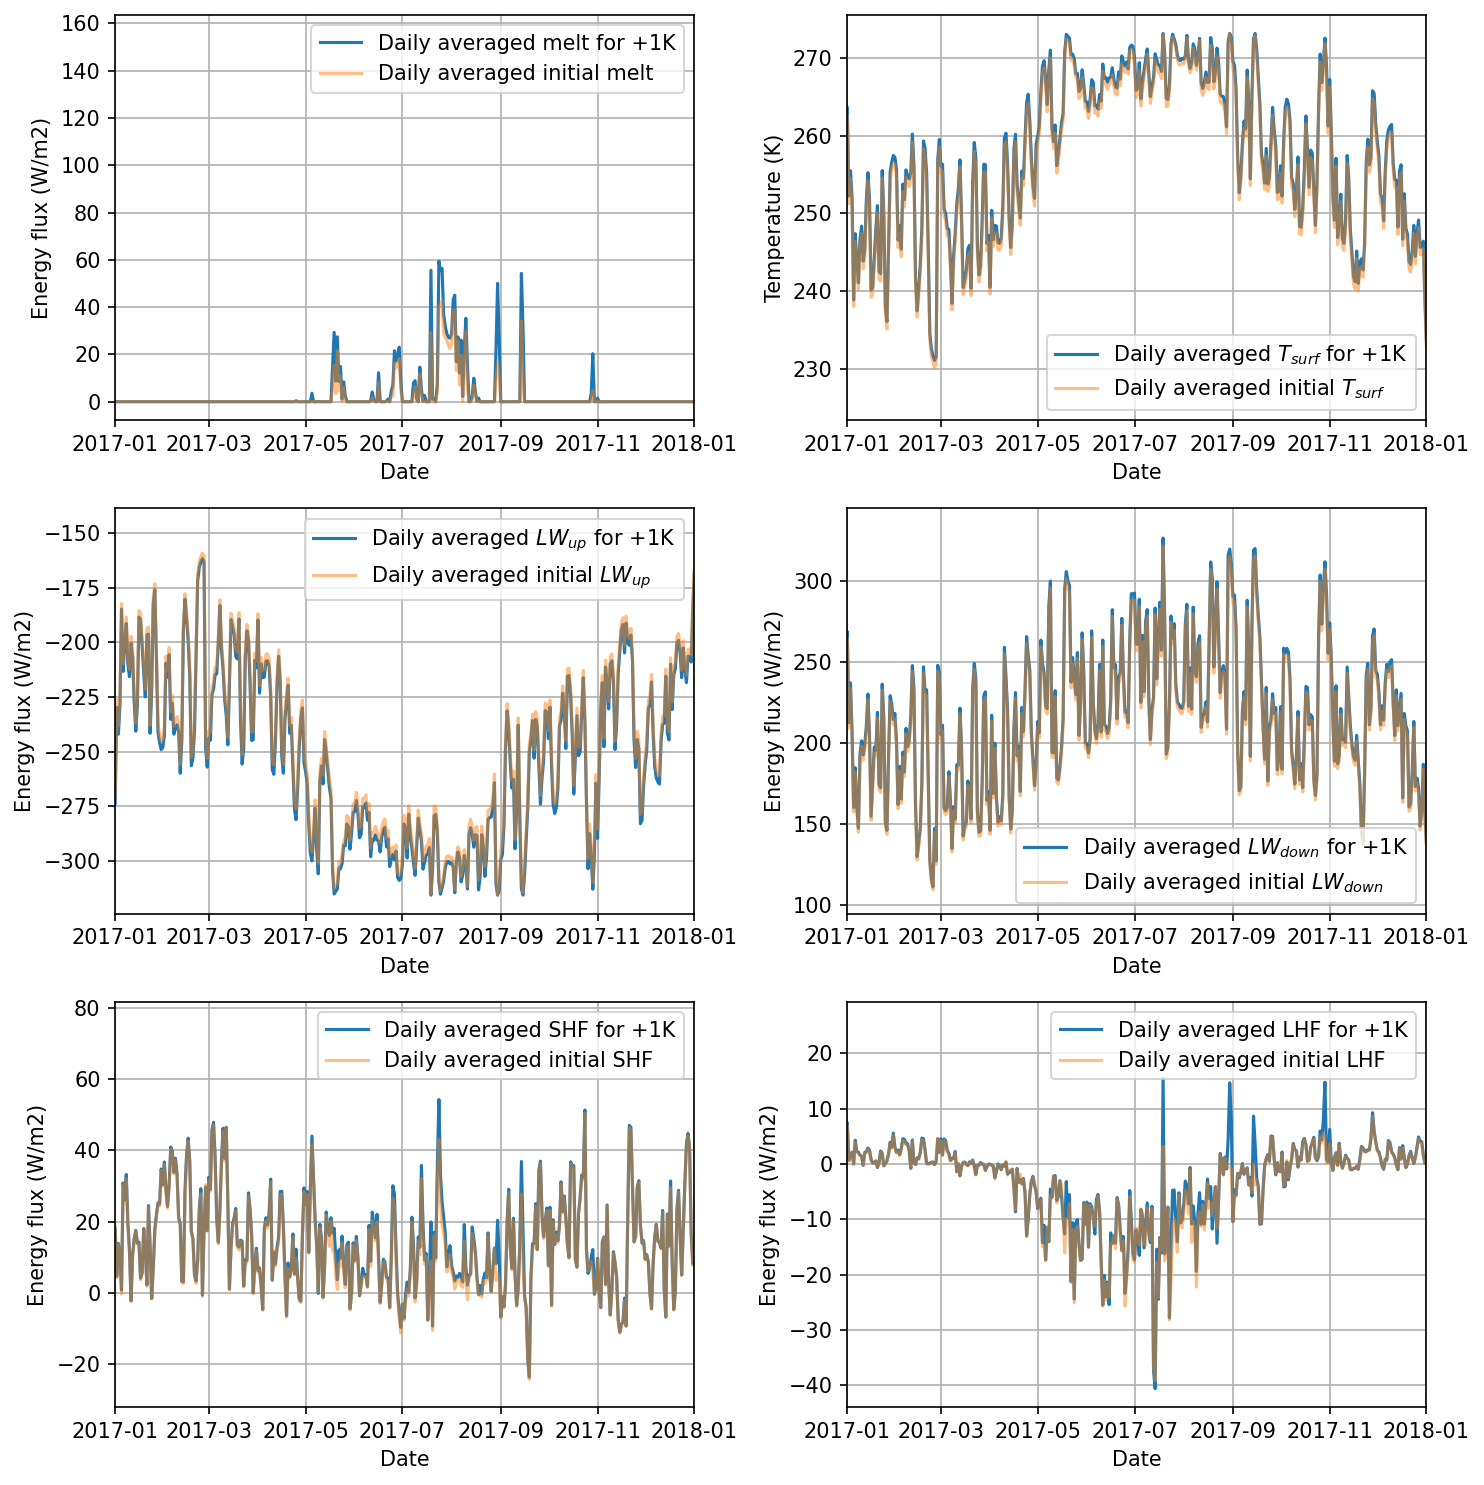

In [239]:
fig,axs = plt.subplots(3,2,figsize=(10,10),dpi=150,sharey=False)

plot_nice_figures(SEBdata, melt_dict_fluxes['Melt'],SEB.melt_initial,'melt',ax= axs[0,0],differences=False)
plot_nice_figures(SEBdata, melt_dict_fluxes['T_surf'],SEB.T_surface,'$T_{surf}$', ax=axs[0,1],differences=False)
plot_nice_figures(SEBdata, melt_dict_fluxes['LW_adj_up'],-1*np.array(SEB.LWup),'$LW_{up}$', ax=axs[1,0],differences=False)
plot_nice_figures(SEBdata, melt_dict_fluxes['LW_adj_down'],SEB.LWdown,'$LW_{down}$', ax=axs[1,1],ylabel=True,differences=False)
plot_nice_figures(SEBdata, melt_dict_fluxes['SHF_adj'],SEB.SHF_initial,'SHF', ax=axs[2,0],differences=False)
plot_nice_figures(SEBdata, melt_dict_fluxes['LHF_adj'],SEB.LHF_initial,'LHF', ax=axs[2,1],ylabel=True,differences=False)
plt.tight_layout()


In [145]:
netLW = [i + j for i, j in zip(melt_dict_fluxes['LW_adj_up'], melt_dict_fluxes['LW_adj_down'])]
netLW_model = [-i + j for i,j in zip(SEB.LWup, SEB.LWdown)]

In [151]:
class FluxPlotter():
    def __init__(self,SEBdata):
        self.SEBdata = SEBdata


    def plot_fluxes(self, SHF,SWdown,SWup,SWnet,LWdown,LWup,LWnet,LHF,Gs,MeltS,Residu):
        PlotType = "Monthly"
        MyFunc = SEBf.get_monthly_average
        Range  = [self.SEBdata.DateTime[0], self.SEBdata.DateTime[-1]]
        Label  = "Year"

        Xdata  = MyFunc(SHF, self.SEBdata.DateTime, GiveDatesBack=True)[1]

        MonthSWdownS = MyFunc(SWdown, self.SEBdata.DateTime, PrintInfo=True)
        MonthSWupS   = MyFunc(SWup, self.SEBdata.DateTime)
        MonthSHFS    = MyFunc(SHF, self.SEBdata.DateTime)

        fig, axs = plt.subplots(2, sharex=True)
        # upper figure are the radiative fluxes
        axs[0].plot(Xdata, MonthSWdownS, 'b', linewidth=0.5, label="$SW_{down}$")
        axs[0].plot(Xdata, -MonthSWupS, 'b:', linewidth=0.5, label="$SW_{up}$")
        axs[0].plot(Xdata, MyFunc(LWdown, self.SEBdata.DateTime), 'r', linewidth=0.5, label="$LW_{down}$")
        axs[0].plot(Xdata, MyFunc(-LWup, self.SEBdata.DateTime), 'r:', linewidth=0.5, label="$LW_{up}$")
        axs[0].plot(Xdata, MyFunc(SWnet+LWnet, self.SEBdata.DateTime), 'k', linewidth=0.5, label="$R_{net}$")
        axs[0].set_ylabel("Energy flux (W/m2)")
        axs[0].legend(loc='lower right') # well, no spot is nice
        axs[0].grid(True)

        axs[1].plot(Xdata, MyFunc(SWnet, SEBdata.DateTime), 'b', linewidth=0.5, label="$SW_{net}$")
        axs[1].plot(Xdata, MyFunc(LWnet, self.SEBdata.DateTime), 'r', linewidth=0.5, label="$LW_{net}$")
        axs[1].plot(Xdata, MyFunc(SHF, self.SEBdata.DateTime), 'seagreen', linewidth=0.5, label="$SHF$")
        axs[1].plot(Xdata, MyFunc(LHF, self.SEBdata.DateTime), 'orange', linewidth=0.5, label="$LHF$")
        axs[1].plot(Xdata, MyFunc(Gs, self.SEBdata.DateTime), 'grey', linewidth=0.5, label="$Gs$")
        axs[1].plot(Xdata, MyFunc(MeltS, self.SEBdata.DateTime), 'purple', linewidth=0.5, label="$M$")
        axs[1].plot(Xdata, MyFunc(Residu, self.SEBdata.DateTime), 'k', linewidth=0.5, label="Res")

        axs[1].set_ylabel("Energy flux (W/m2)")
        axs[1].legend(loc='lower right') # Again, no spot is nice
        axs[1].set_xlabel(Label)
        axs[1].set_xlim(Range)
        axs[1].grid(True)



The date and hour of the first entry is April 05, 2009, 00:00.
First full month starts at May 01, 2009, 00:00
The date and hour of the last entry is September 23, 2019, 23:00.
Last full month end at August 31, 2019, 23:00
The dataset contains data of 125 months.
The date and hour of the first entry is April 05, 2009, 00:00.
First full month starts at May 01, 2009, 00:00
The date and hour of the last entry is September 23, 2019, 23:00.
Last full month end at August 31, 2019, 23:00
The dataset contains data of 125 months.
The date and hour of the first entry is April 05, 2009, 00:00.
First full month starts at May 01, 2009, 00:00
The date and hour of the last entry is September 23, 2019, 23:00.
Last full month end at August 31, 2019, 23:00
The dataset contains data of 125 months.


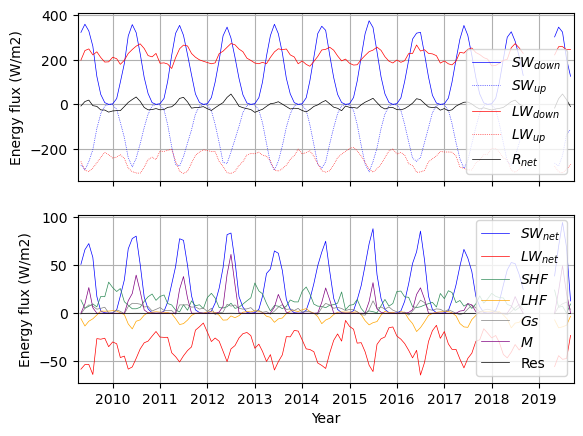

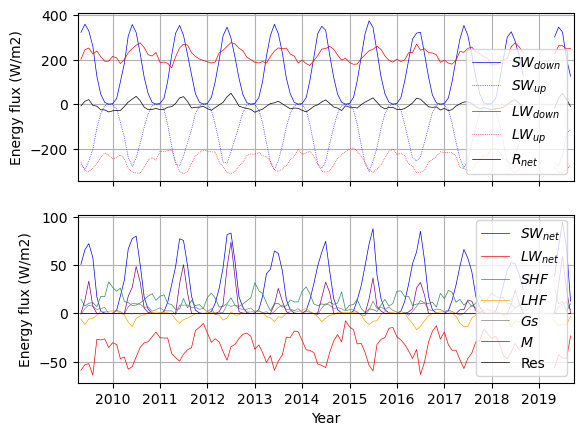

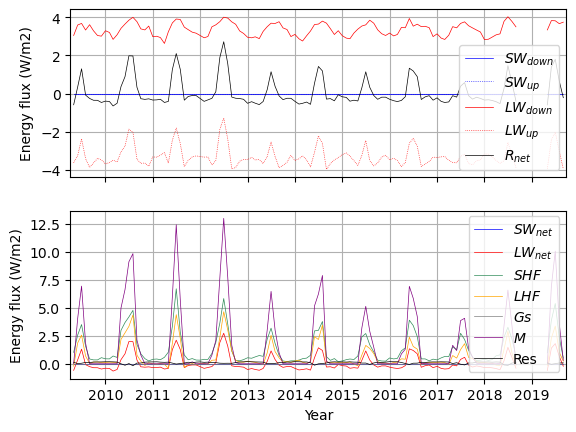

In [153]:
plotter = FluxPlotter(SEBdata)
plotter.plot_fluxes(SHF=SEB.SHF_initial,SWdown=SEB.SWdown,SWup=SEB.SWup,SWnet=SEB.SWnet,LWdown=SEB.LWdown,LWup=SEB.LWup,LWnet=SEB.LWnet_model,LHF=SEB.LHF_initial,Gs=SEB.G,MeltS=SEB.melt_initial,Residu=SEB.res_initial)
plotter.plot_fluxes(SHF=melt_dict_fluxes['SHF_adj'], SWdown=SEB.SWdown,SWup=SEB.SWup,SWnet=SEB.SWnet,LWdown=melt_dict_fluxes['LW_adj_down'], LWup=-1*np.array(melt_dict_fluxes['LW_adj_up']),LWnet=netLW,LHF=melt_dict_fluxes['LHF_adj'],Gs=SEB.G,MeltS=melt_dict_fluxes['Melt'],Residu=melt_dict_fluxes['Res'])
# plotter.plot_fluxes(SHF=SEB.SHF_initial-melt_dict_fluxes['SHF_adj'], SWdown=SEB.SWdown-SEB.SWdown,SWup=SEB.SWup-SEB.SWup, SWnet=SEB.SWnet-SEB.SWnet,LWdown=SEB.LWdown-melt_dict_fluxes['LW_adj_down'],LWup=SEB.LWup+np.array(melt_dict_fluxes['LW_adj_up']),LWnet = (np.array(SEB.LWup)-np.array(SEB.LWdown))+np.array(netLW),LHF=SEB.LHF_initial-melt_dict_fluxes['LHF_adj'],Gs=SEB.G-SEB.G,MeltS=SEB.melt_initial-melt_dict_fluxes['Melt'],Residu=SEB.res_initial-melt_dict_fluxes['Res'] )
plotter.plot_fluxes(
    SHF=melt_dict_fluxes['SHF_adj'] - SEB.SHF_initial,
    SWdown=SEB.SWdown - SEB.SWdown,
    SWup=SEB.SWup - SEB.SWup,
    SWnet=SEB.SWnet - SEB.SWnet,
    LWdown=melt_dict_fluxes['LW_adj_down'] - SEB.LWdown,
    LWup=-1*np.array(melt_dict_fluxes['LW_adj_up']) - SEB.LWup,
    LWnet=np.array(netLW)+(np.array(SEB.LWup)-np.array(SEB.LWdown)),
    LHF=melt_dict_fluxes['LHF_adj'] - SEB.LHF_initial,
    Gs=SEB.G - SEB.G,
    MeltS=melt_dict_fluxes['Melt'] - SEB.melt_initial,
    Residu=melt_dict_fluxes['Res'] - SEB.res_initial
)

In [154]:
melt_1k = SEB.fetch_SEB(LWadjdown=SEB.LWadjdown(SEB.T_air, dT=1), dT=1, idxmax=10)
melt_min1k = SEB.fetch_SEB(LWadjdown=SEB.LWadjdown(SEB.T_air, dT=-1), dT=-1, idxmax=10)
no_melt = SEB.fetch_SEB(LWadjdown=SEB.LWadjdown(SEB.T_air, dT=0), dT=0, idxmax=10)

melt_arr = [no_melt['Melt'], melt_1k['Melt'], melt_min1k['Melt']]
dt_arr = [0, 1, -1]

In [240]:
import datetime
def cum_melt(SEBdata,melt_arr,dt_arr):
    plt.figure(dpi=150)
    for melt, dt in zip(melt_arr, dt_arr):
        plt.plot(SEBdata.DateTime, SEBf.get_running_melt_sum(melt,SEBdata.TimeStep, ResetAtNan=True), label=f'Melt for dT of {dt}K')
    plt.plot(SEBdata.DateTime, SEBf.get_running_melt_sum(SEB.melt_initial,SEBdata.TimeStep,ResetAtNan=True), label='Initial melt')
    plt.legend()
    plt.xlabel('Time (Year)')
    plt.ylim(0,20)
    plt.xlim([datetime.datetime(2009, 1, 1), datetime.datetime(2018, 12, 31)])
    plt.ylabel('Accumulated melt (m w.e.)')
    plt.grid()

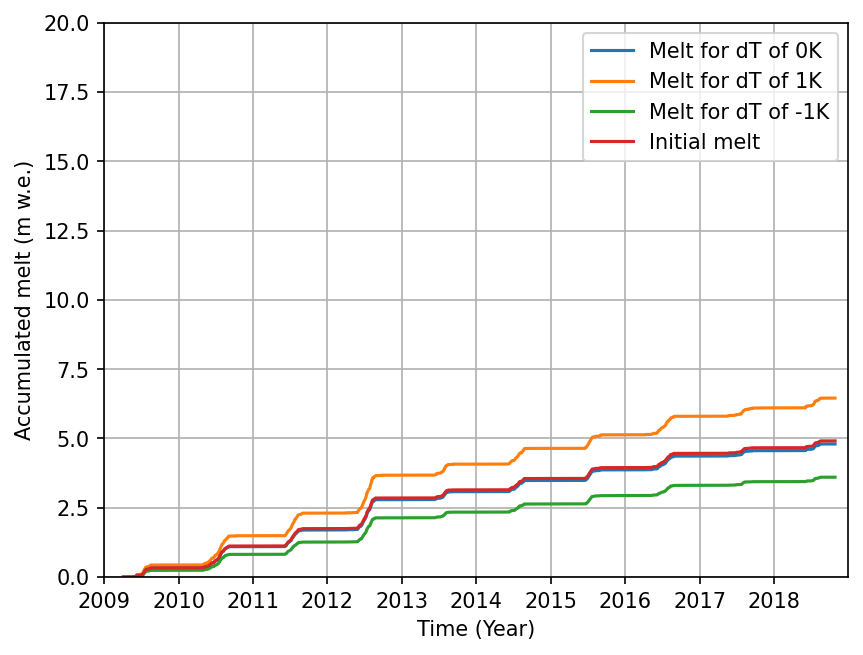

In [241]:
cum_melt(SEBdata, melt_arr, dt_arr)